In [9]:
import boto3
import json
import datetime
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [2]:
start_date_str = '2023-05-03'
end_date_str = '2023-05-05'
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

In [3]:
# get a list of all json files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=CANSERVER_EVENT_BUCKET, Prefix="hamid/k3y-9ed5b50e/")
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered json files
event_dict = {}
for key in keys:
    response = s3_client.get_object(Bucket=CANSERVER_EVENT_BUCKET, Key=key)
    result = json.loads(response["Body"].read().decode())
    for index in result['imu_telematics']:
        if index in event_dict:
            event_dict[index].extend(result['imu_telematics'][index])
        else:
            event_dict[index] = result['imu_telematics'][index]


In [4]:
# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=CANSERVER_PARSED_BUCKET, Prefix="hamid/k3y-9ed5b50e/")
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=CANSERVER_PARSED_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(df)
df = pd.concat(df_list, axis=0, ignore_index=True)

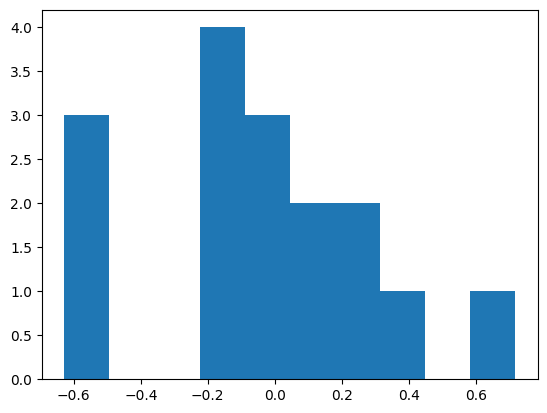

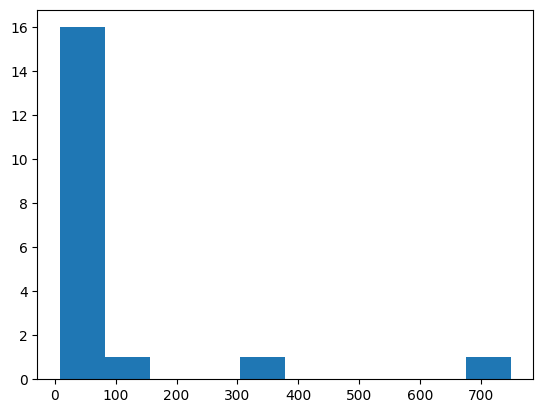

In [5]:
mean_bf_acc = []
ss_time = []

for state in event_dict['stationary_state']:
    ss_start_time = state['start']
    ss_end_time = state['end']
    ss_motion = df[(df['timestamp'] >= ss_start_time) & (df['timestamp'] <= ss_end_time)]

    mean_bf_acc.append(ss_motion['bf_acc'].mean())
    ss_time.append(ss_end_time - ss_start_time)

plt.hist(mean_bf_acc)
plt.show()
plt.hist(ss_time)
plt.show()

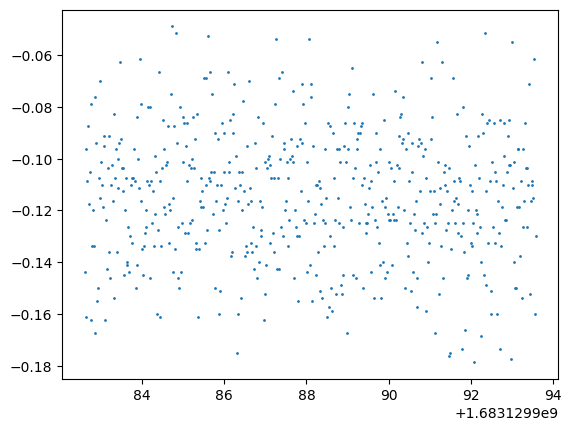

In [7]:
# plotting the stationary state accelerations

state_num = 0

ss_start_time = event_dict['stationary_state'][state_num]['start']
ss_end_time = event_dict['stationary_state'][state_num]['end']
ss_motion = df[(df['timestamp'] >= ss_start_time) & (df['timestamp'] <= ss_end_time)]

fig, ax = plt.subplots()
ax.scatter(x=ss_motion['timestamp'], y=ss_motion['lr_acc'], s=1)

plt.show()